In [1]:
import os, re, cv2
import matplotlib.pyplot as plt
import numpy as np

from utils.defisheye import Defisheye
from utils.surround_view import blend_bird_eye_img_v1
from tqdm.notebook import tqdm

In [2]:
file_list = os.listdir("e:\\result")
file_list = sorted(file_list, key=lambda x: int(re.search(r'\d+', x).group()))

front_img_cal = np.load("parameter\\fish_eye_img\\front_img_cal.npy")
rear_img_cal = np.load("parameter\\fish_eye_img\\rear_img_cal.npy")
left_img_cal = np.load("parameter\\fish_eye_img\\left_img_cal.npy")
right_img_cal = np.load("parameter\\fish_eye_img\\right_img_cal.npy")

img_pos = {'front': [[0, 540], [0, 960]],
           'rear':[[0, 540], [960, 1980]],
           'left': [[540, 1080], [0, 960]],
           'right':[[540, 1080], [960, 1980]]}

img = cv2.imread(f"e:\\result\\{file_list[100]}")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
front_img = img[img_pos['front'][0][0]:img_pos['front'][0][1], img_pos['front'][1][0]:img_pos['front'][1][1]]

defisheye = Defisheye(front_img, dtype='equalarea', format='fullframe', fov=360, pfov=120, pad=270)

In [3]:
front_img = img[img_pos['front'][0][0]:img_pos['front'][0][1],img_pos['front'][1][0]:img_pos['front'][1][1]]
rear_img = img[img_pos['rear'][0][0]:img_pos['rear'][0][1], img_pos['rear'][1][0]:img_pos['rear'][1][1]]
left_img = img[img_pos['left'][0][0]:img_pos['left'][0][1], img_pos['left'][1][0]:img_pos['left'][1][1]]
right_img = img[img_pos['right'][0][0]:img_pos['right'][0][1], img_pos['right'][1][0]:img_pos['right'][1][1]]

img_list = [front_img, rear_img, left_img, right_img]

In [4]:
conv_img_list = []
dst_img_list = []

for img, img_cal in zip(tqdm(img_list), [front_img_cal, rear_img_cal, left_img_cal, right_img_cal]):
    conv_img = defisheye.convert(img)[150:940]
    h, w = conv_img.shape[:2]
    dst_img = cv2.warpPerspective(src=conv_img, M=img_cal, dsize=(w, int(h)), flags=cv2.INTER_LINEAR, borderValue=(0, 0, 0))[:, 100:980]
    dst_img_list.append(dst_img)

  0%|          | 0/4 [00:00<?, ?it/s]

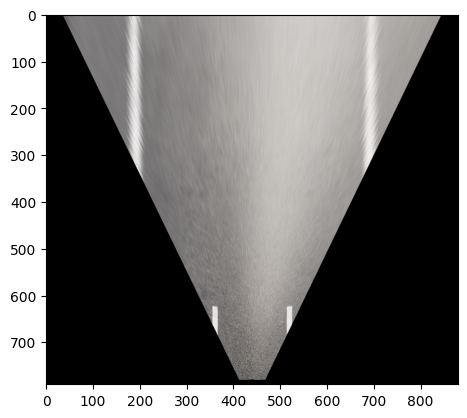

In [5]:
plt.imshow(dst_img_list[0])

Text(0.5, 1.0, 'right image')

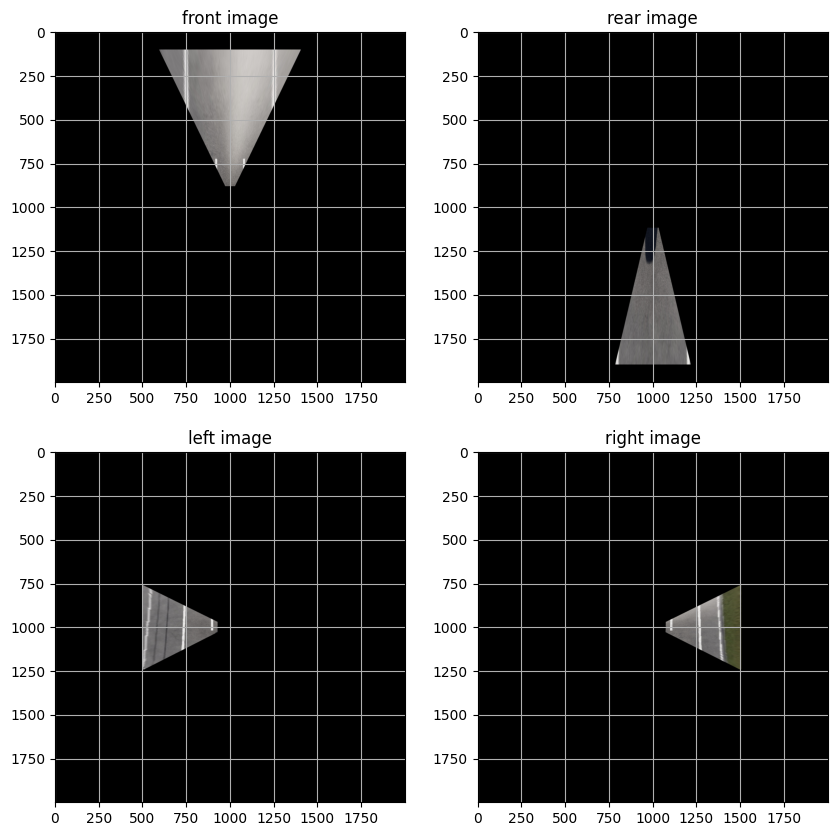

In [6]:
front_img = dst_img_list[0]
rear_img = dst_img_list[1]
left_img = dst_img_list[2]
right_img = dst_img_list[3]

left_img = cv2.resize(left_img, fx=0.55, fy=0.55, dsize=(0, 0), interpolation=cv2.INTER_AREA)
right_img = cv2.resize(right_img, fx=0.55, fy=0.55, dsize=(0, 0), interpolation=cv2.INTER_AREA)
rear_img = cv2.resize(rear_img, fx=0.6, fy=1, dsize=(0, 0), interpolation=cv2.INTER_AREA)

left_img_rot = cv2.rotate(src=left_img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
right_img_rot = cv2.rotate(src=right_img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
rear_img_rot = cv2.rotate(src=rear_img, rotateCode=cv2.ROTATE_180)

top_offset = 100
left_offset = 500
right_offset = left_offset

border_color = (0, 0, 0)

img_size = 2000


front_img_h_offset = int((img_size-(front_img.shape[1]))/2)
rear_img_h_offset = int((img_size-(rear_img_rot.shape[1]))/2)
horizontal_img_v_offset = int((img_size-(left_img_rot.shape[0]))/2)

front_ext = cv2.copyMakeBorder(front_img, top_offset, img_size-front_img.shape[0]-top_offset,
                               front_img_h_offset, front_img_h_offset, cv2.BORDER_CONSTANT, value=border_color)

rear_ext = cv2.copyMakeBorder(rear_img_rot, img_size-rear_img_rot.shape[0]-top_offset, top_offset,
                              rear_img_h_offset, rear_img_h_offset, cv2.BORDER_CONSTANT, value=border_color)

left_ext = cv2.copyMakeBorder(left_img_rot, horizontal_img_v_offset, horizontal_img_v_offset, left_offset, img_size-left_img_rot.shape[1]-left_offset, cv2.BORDER_CONSTANT, value=border_color)

right_ext = cv2.copyMakeBorder(right_img_rot, horizontal_img_v_offset, horizontal_img_v_offset,
                               img_size-right_img_rot.shape[1]-right_offset, right_offset, cv2.BORDER_CONSTANT, value=border_color)

fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)

axis[0, 0].imshow(front_ext)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_ext)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_ext)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_ext)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

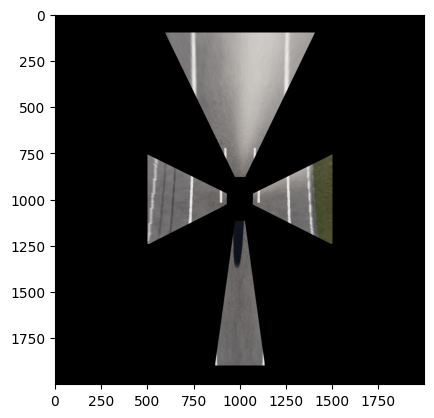

In [28]:
plt.imshow(front_ext+rear_ext+left_ext+right_ext)

In [ ]:
gray = cv2.cvtColor(src=front_ext, code=cv2.COLOR_BGR2GRAY)
_, front_img_mask = cv2.threshold(gray, thresh=1, maxval=255, type=cv2.THRESH_BINARY)

gray = cv2.cvtColor(src=left_ext, code=cv2.COLOR_BGR2GRAY)
_, left_img_mask = cv2.threshold(gray, thresh=1, maxval=255, type=cv2.THRESH_BINARY)

gray = cv2.cvtColor(src=right_ext, code=cv2.COLOR_BGR2GRAY)
_, right_img_mask = cv2.threshold(gray, thresh=1, maxval=255, type=cv2.THRESH_BINARY)

gray = cv2.cvtColor(src=rear_ext, code=cv2.COLOR_BGR2GRAY)
_, rear_img_mask = cv2.threshold(gray, thresh=1, maxval=255, type=cv2.THRESH_BINARY)

a = np.bitwise_and(front_img_mask, left_img_mask)
b = np.bitwise_and(front_img_mask, right_img_mask)
c = np.bitwise_and(rear_img_mask, left_img_mask)
d = np.bitwise_and(rear_img_mask, right_img_mask)

e = a + b + c + d

front_ext[e == 255] = (0, 0, 0)
rear_ext[e == 255] = (0, 0, 0)

result_img = front_ext + rear_ext + left_ext + right_ext